In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from qqe.backend import QuimbBackend
from qqe.circuit.families import (
    CliffordBrickwork,
    HaarBrickwork,
    QuansistorBrickwork,
    RandomCircuit,
)
from qqe.circuit.gates import clifford_recipe_unitary
from qqe.experiments.plotting import plot_pennylane_circuit
from qqe.GNN import circuit_spec_to_nx_dag


In [2]:
family_registry = {
    "haar": HaarBrickwork,
    "clifford": CliffordBrickwork,
    "quansistor": QuansistorBrickwork,
    "random": RandomCircuit,
}

In [3]:
n_qubits = 8
n_layers = 10

In [4]:
circuit = family_registry["clifford"]()

In [5]:
circuit_spec = circuit.make_spec(
    n_qubits=n_qubits,
    n_layers=n_layers,
    d=2,
    seed=4,
)
type(circuit_spec)

qqe.circuit.spec.CircuitSpec

In [6]:
print(circuit_spec.gates)

(GateSpec(kind='I', wires=(0,), d=2, seed=7051113909731422037, tags=('layer', 'L0', 'clifford_1q', 'wire_0', 'ua_I'), params=()), GateSpec(kind='H', wires=(1,), d=2, seed=7051113909731422037, tags=('layer', 'L0', 'clifford_1q', 'wire_1', 'ub_H'), params=()), GateSpec(kind='CNOT', wires=(0, 1), d=2, seed=7051113909731422037, tags=('layer', 'L0', 'clifford_2q', 'wire_0_1'), params=()), GateSpec(kind='H', wires=(2,), d=2, seed=4809760331336844183, tags=('layer', 'L0', 'clifford_1q', 'wire_2', 'ua_H'), params=()), GateSpec(kind='H', wires=(3,), d=2, seed=4809760331336844183, tags=('layer', 'L0', 'clifford_1q', 'wire_3', 'ub_H'), params=()), GateSpec(kind='CNOT', wires=(2, 3), d=2, seed=4809760331336844183, tags=('layer', 'L0', 'clifford_2q', 'wire_2_3'), params=()), GateSpec(kind='H', wires=(4,), d=2, seed=3479166546898591396, tags=('layer', 'L0', 'clifford_1q', 'wire_4', 'ua_H'), params=()), GateSpec(kind='S', wires=(5,), d=2, seed=3479166546898591396, tags=('layer', 'L0', 'clifford_1q', 

In [7]:
dag = circuit_spec_to_nx_dag(circuit_spec)

In [8]:
pos = {}
layer_node_counts = {}

for node, attrs in dag.nodes(data=True):
    layer = attrs["subset"]
    wires = attrs["wires"]

    # Count nodes at each layer for vertical spacing
    if layer not in layer_node_counts:
        layer_node_counts[layer] = 0

    # Position x by layer, y by qubit(s) involved
    x = layer * 2  # Horizontal spacing by layer
    y = -sum(wires) / len(wires)  # Average qubit index (negative for better layout)

    pos[node] = (x, y)

# Create custom labels based on node attributes
labels = {}
for node, attrs in dag.nodes(data=True):
    kind = attrs["kind"]
    wires = attrs["wires"]
    tags = attrs["tags"]

    # Format wire display
    wire_str = f"q{wires[0]}" if len(wires) == 1 else f"q{wires[0]}-q{wires[1]}"

    # Check for special tag info
    special_tag = None
    if "T-gate" in tags:
        special_tag = "T"
    elif kind == "clifford":
        # First check if decomposition is already in tags
        decomp_tag = None
        for tag in tags:
            if isinstance(tag, str) and tag.startswith("decomp_"):
                decomp_tag = tag.replace("decomp_", "")
                break

        if decomp_tag:
            special_tag = decomp_tag
        else:
            # Fallback: compute from seed
            gate_spec = circuit_spec.gates[node]
            if gate_spec.seed is not None:
                u_a, u_b, _ = clifford_recipe_unitary(gate_spec.seed)
                special_tag = f"{u_a}⊗{u_b}+CX"
            else:
                special_tag = "Cliff"
    elif kind == "quansistor":
        # Extract axis if present
        for tag in tags:
            if isinstance(tag, str) and tag.startswith("axis_"):
                axis = tag.split("_")[1]
                special_tag = f"Q-{axis}"
                break
        if special_tag is None:
            special_tag = "Q"

    # Create concise label
    if special_tag:
        labels[node] = f"{special_tag}\n{wire_str}"
    else:
        labels[node] = f"{kind}\n{wire_str}"

# Color nodes by gate type
gate_colors = {
    "RX": "#FF6B6B",  # Red
    "RY": "#4ECDC4",  # Teal
    "RZ": "#45B7D1",  # Blue
    "H": "#FFA07A",  # Light Salmon
    "S": "#98D8C8",  # Mint
    "T": "#F7DC6F",  # Yellow
    "CNOT": "#BB8FCE",  # Purple
    "clifford": "#D2B4DE",  # Lavender
    "quansistor_X": "#A9DFBF",  # Light Green for X-axis
    "quansistor_Y": "#F8B88B",  # Light Orange for Y-axis
    "quansistor": "#D5D8DC",  # Gray (fallback)
    "haar": "#FAD7A0",  # Peach
}

# Assign colors based on gate type and axis
node_colors = []
for node in dag.nodes():
    kind = dag.nodes[node]["kind"]
    tags = dag.nodes[node]["tags"]

    if kind == "quansistor":
        # Extract axis from tags
        axis = None
        for tag in tags:
            if isinstance(tag, str) and tag.startswith("axis_"):
                axis = tag.split("_")[1]
                break

        if axis:
            node_colors.append(
                gate_colors.get(f"quansistor_{axis}", gate_colors["quansistor"]),
            )
        else:
            node_colors.append(gate_colors["quansistor"])
    else:
        node_colors.append(gate_colors.get(kind, "#D3D3D3"))

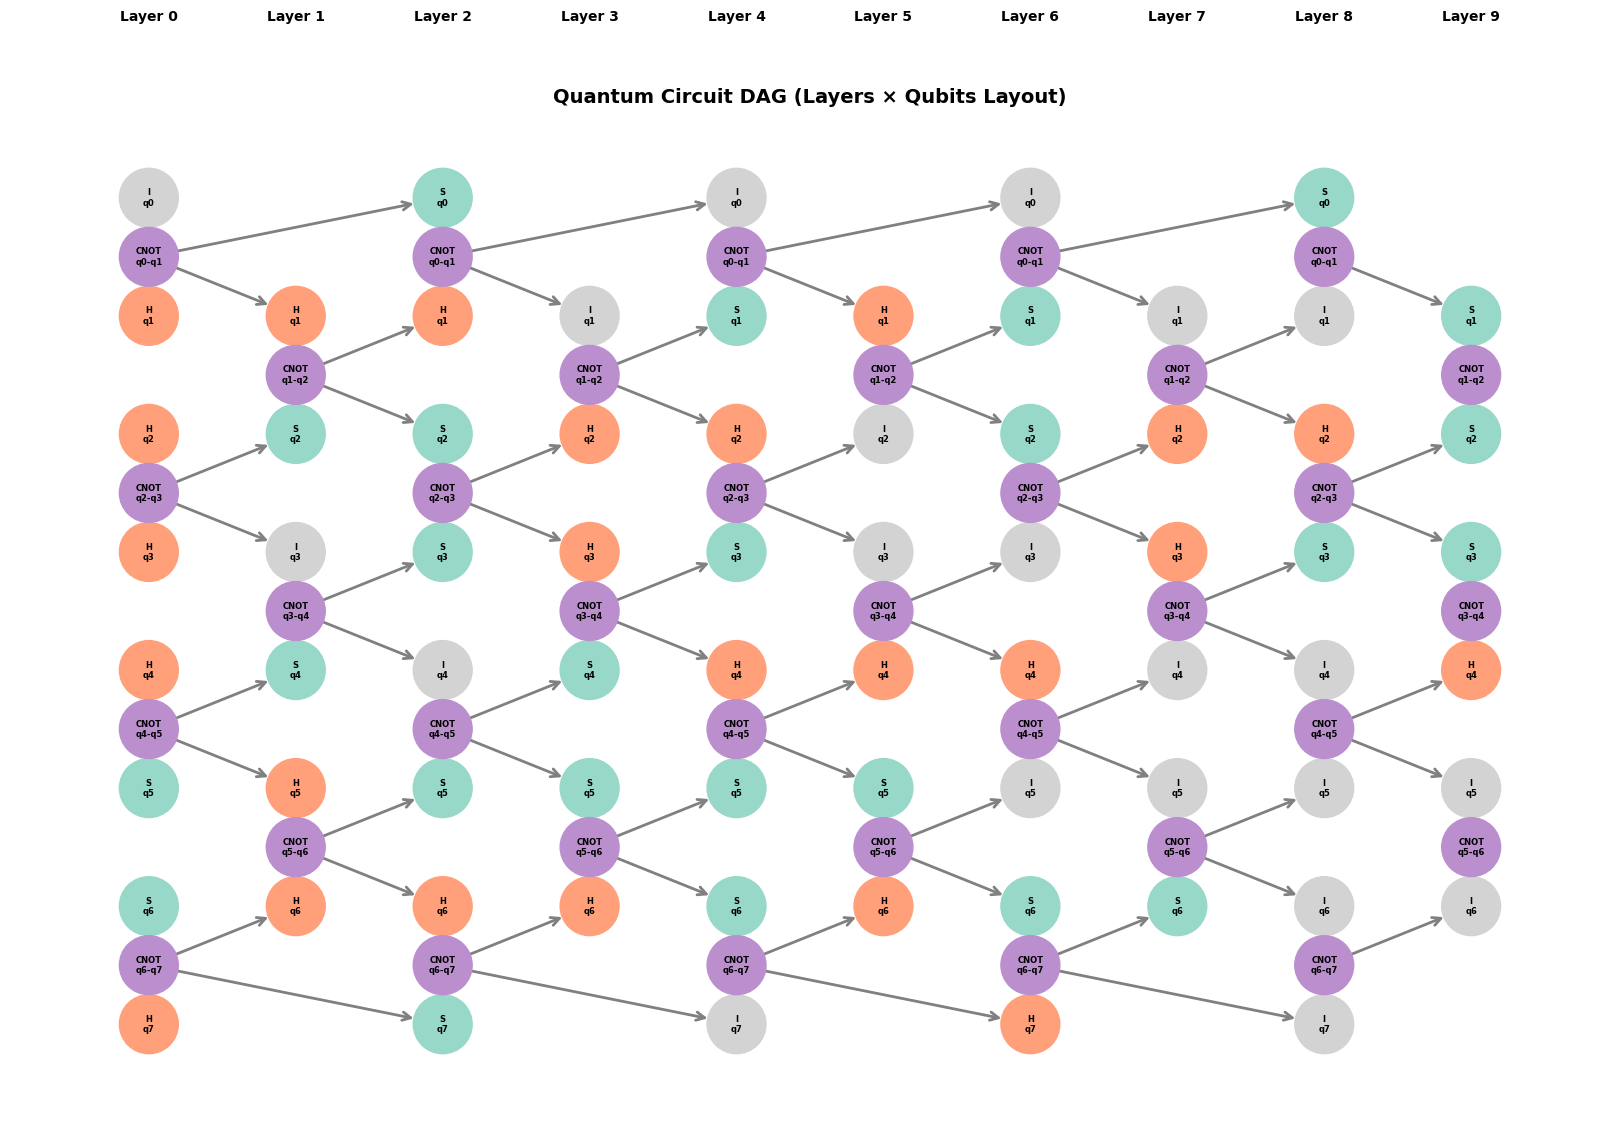

In [9]:
plt.figure(figsize=(16, 10))
nx.draw(
    dag,
    pos=pos,
    labels=labels,
    with_labels=True,
    node_size=1800,
    node_color=node_colors,
    arrowsize=15,
    arrowstyle="->",
    edge_color="gray",
    width=2,
    font_size=6,
    font_color="black",
    font_weight="bold",
)
layer_positions = {}
for layer in layer_node_counts:
    layer_positions[layer] = layer * 2

ax = plt.gca()
for layer, x in layer_positions.items():
    ax.text(
        x,
        max([p[1] for p in pos.values()]) + 1.5,
        f"Layer {layer}",
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

plt.title("Quantum Circuit DAG (Layers × Qubits Layout)", fontsize=14, fontweight="bold")
# plt.tight_layout()
# plt.savefig(f"circuit_outputs/DAG_{circuit.name}.png", dpi=150, bbox_inches="tight")
plt.show()


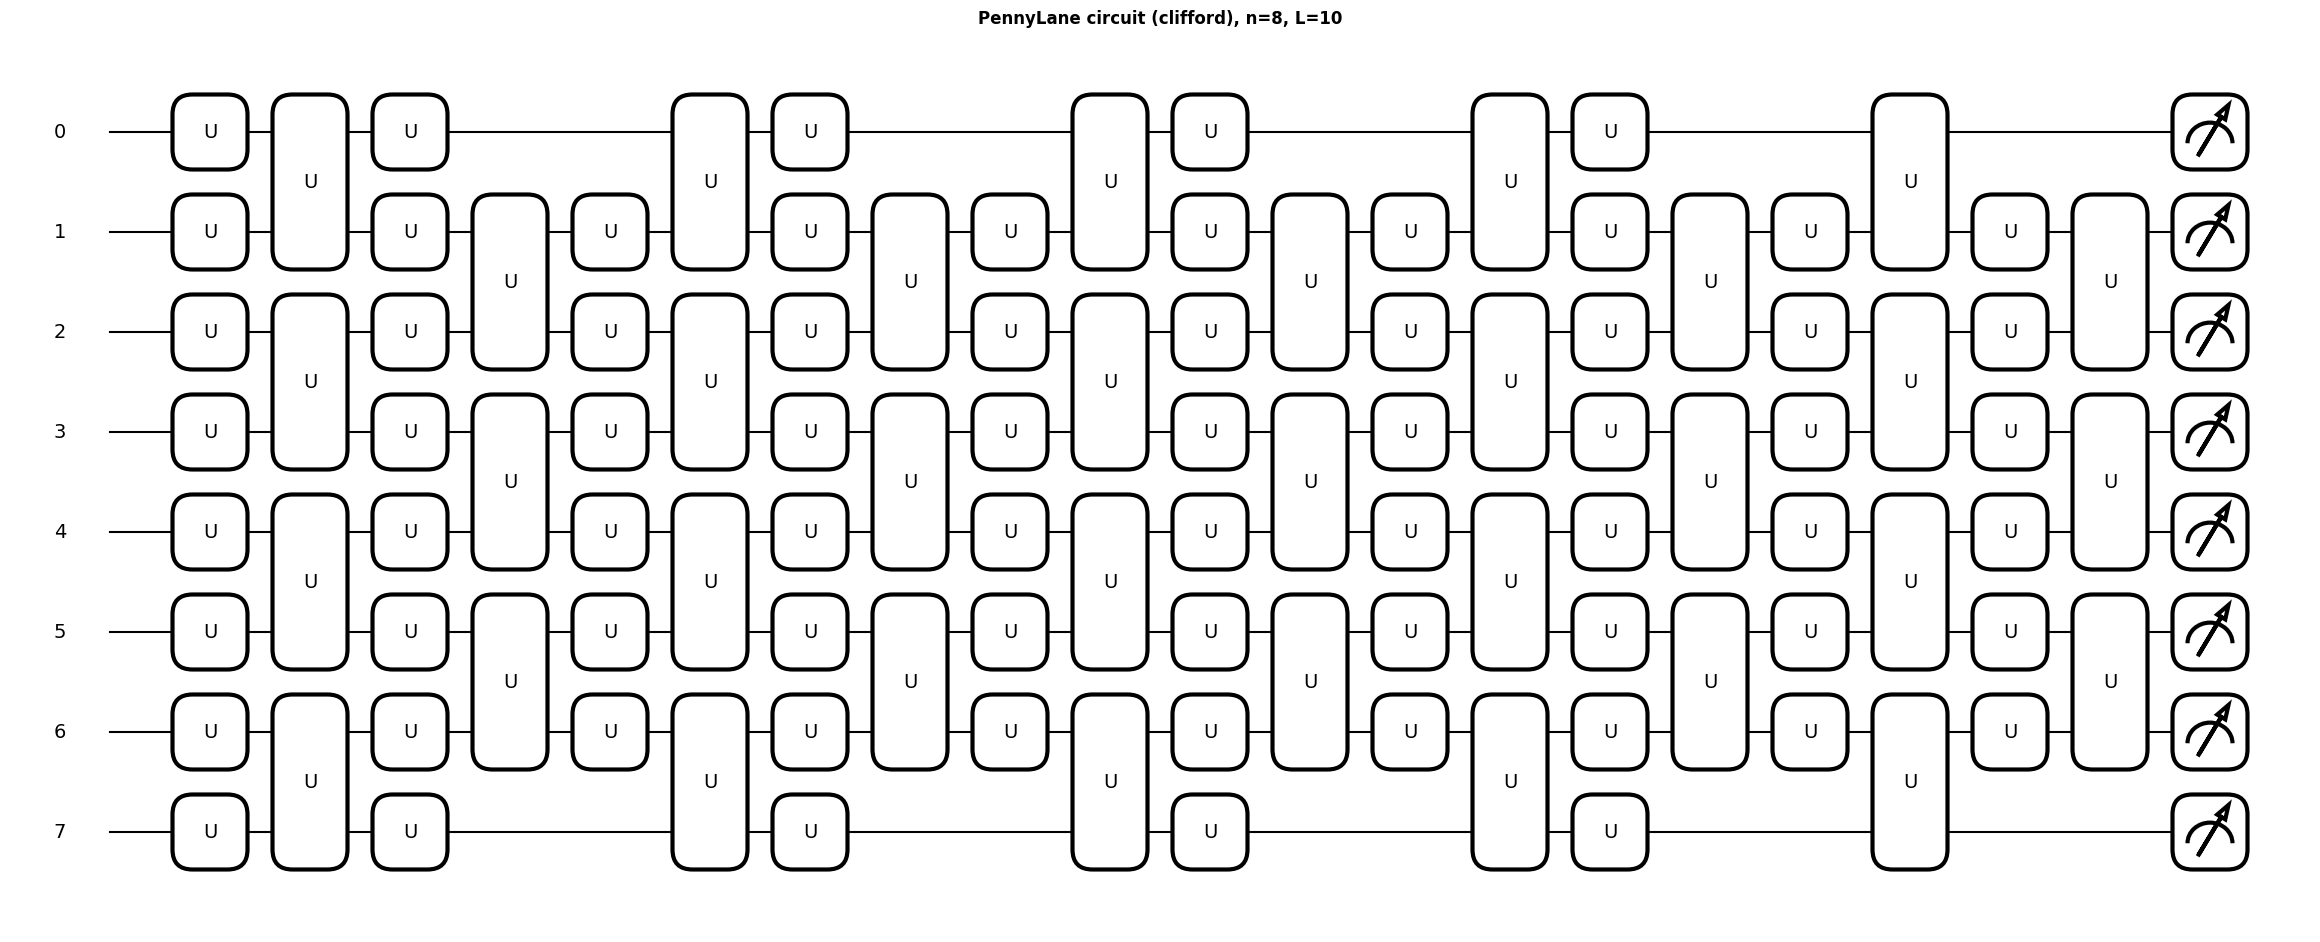

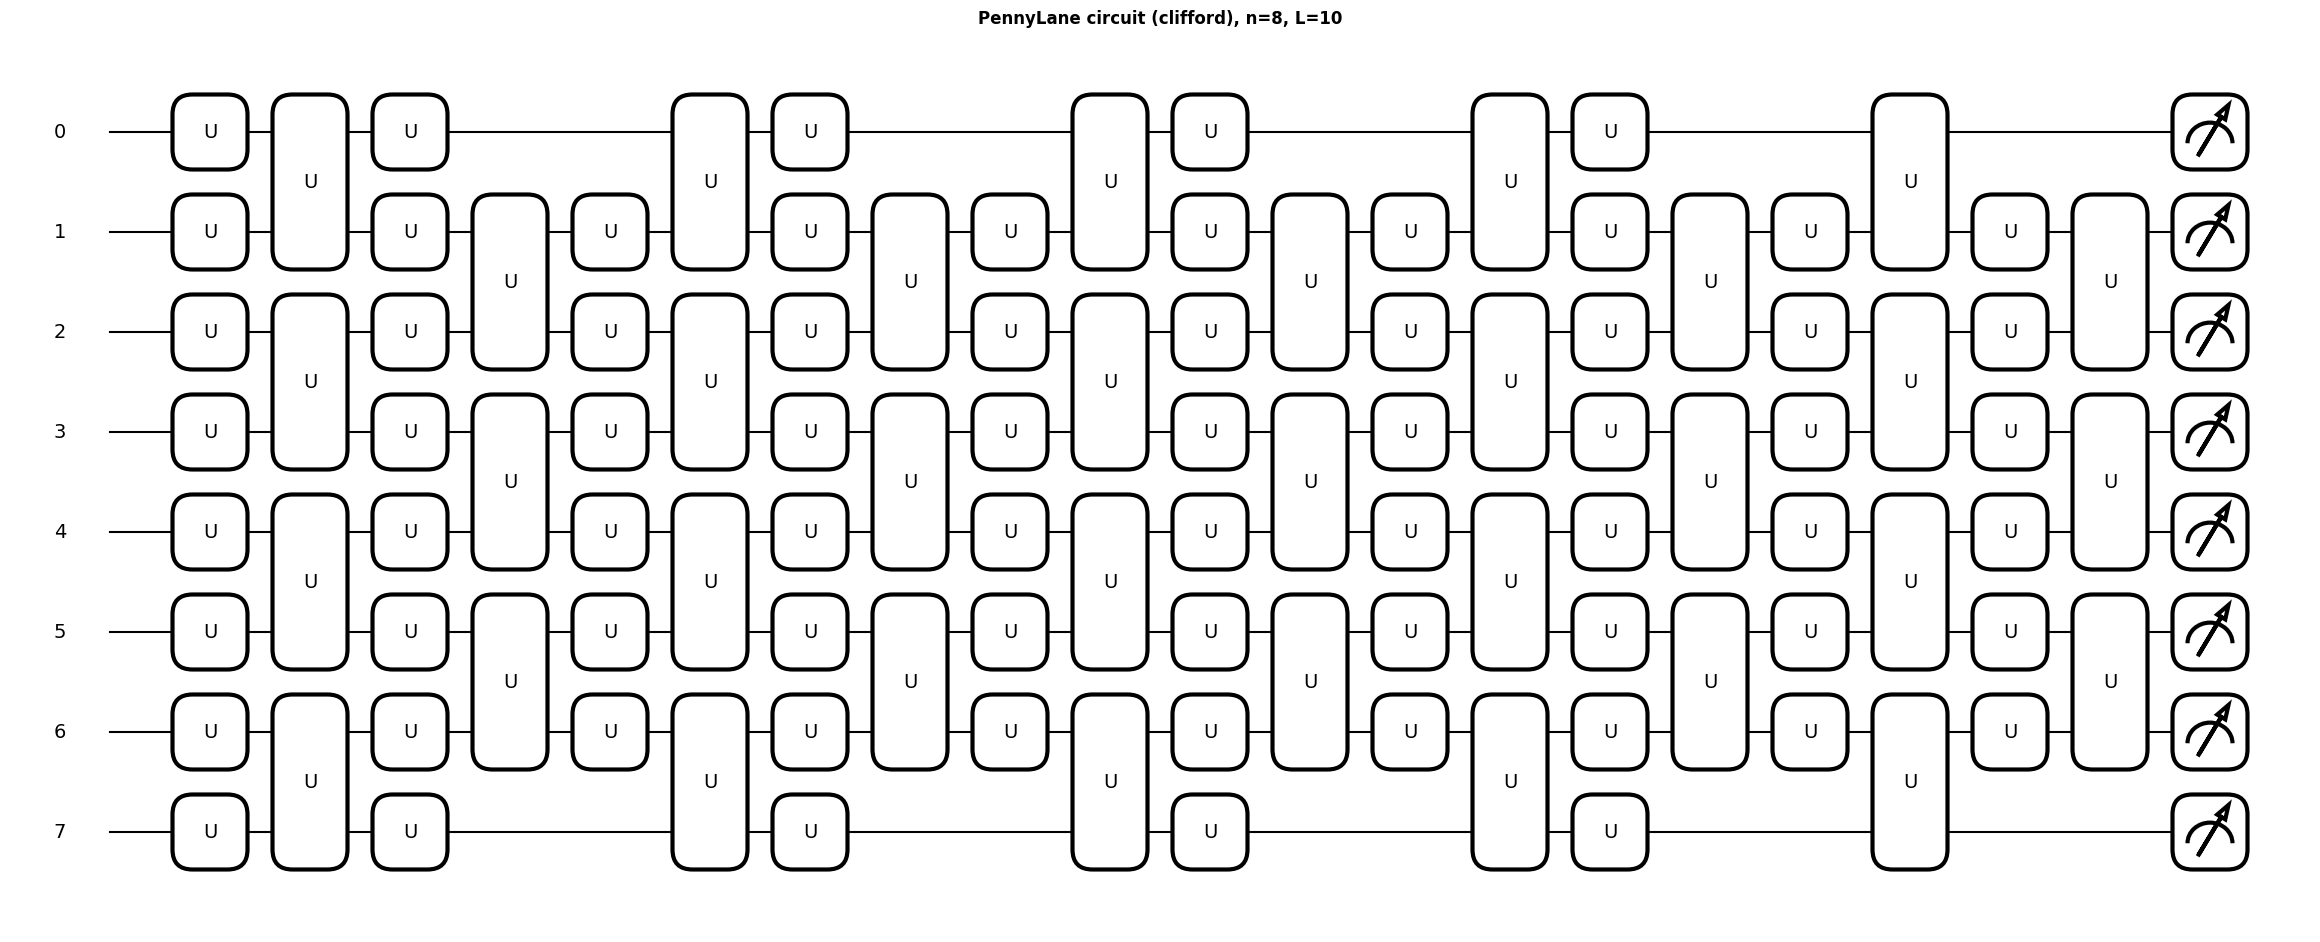

In [10]:
plot_pennylane_circuit(circuit_spec)

In [11]:
backend = QuimbBackend()
state = backend.simulate(circuit_spec)

In [12]:
def in_place_FHWT(arr: np.ndarray):
    """In-place Fast Walsh-Hadamard Transform of array a (length must be power of 2)."""
    n = arr.shape[0]
    h = 1
    while h < n:
        for i in range(0, n, h * 2):
            u = arr[i:i+h]
            v = arr[i+h:i+2*h]
            u[:], v[:] = u + v, u - v
        h *= 2

def sre_fwht(state):
    psi = np.asarray(state.vector, dtype=complex).reshape(-1)
    N = psi.size

    # qubits-only assumption:
    n = int(np.log2(N))
    if 2**n != N:
        raise ValueError(f"FWHT method assumes N=2^n. Got N={N}")

    idx = np.arange(N, dtype=np.int64)

    acc=0.0
    for k in range(N):
        A = np.conjugate(psi[idx ^ k]) * psi   # shape (N,)
        in_place_FHWT(A)
        acc += np.sum(np.abs(A)**4)
    sre = -np.log2(acc/(state.d**n))
    return sre

In [13]:
print(sre_fwht(state))

1.8691993649761256e-13
